# Определение значимых отличий в ЭЭГ в различных видах деятельности

### Представлены данные сигнала пользователя во время различных видах деятельности


- *Спокойный отдых с закрытыми глазами*


- *Спокойное прослушивание музыки с закрытыми глазами*


- *Игра на компьютере*


- *Решение математической задачи*


- *Решение задачи по программированию*

Необходимо определить, существуют ли какие-либо значимые отличия в записи ЭЭГ-сигнала во время различных активностей

Для простоты, приведём подробные данные по **спокойному отдыху с закрытыми глазами**

Остальные данные обработаем таким же образом, приведя лишь итоговые результаты, чтобы не перегружать блокнот

## 1. Загрузка данных

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import os
import numpy as np
import mne

In [2]:
core_path = "data/"

with open(core_path + "basic.dat") as file:
    data = [[float(el) for el in line.split()] for line in file.read().split("\n")]

In [3]:
data = pd.DataFrame(data, columns=["time", "value"])
data.head(15)

,time,value
0,45.733116,1.941176
1,45.737377,2.901961
2,45.741302,2.960784
3,45.741302,3.549020
4,45.745342,2.137255
5,45.749519,1.725490
6,45.749519,1.745098
7,45.753567,2.411765
8,45.757679,3.058824
9,45.761913,3.333333


## 2. Обработка данных

**План обработки данных:**

1. Сделать отсчёт времени относительно нуля

    
2. Убрать (взять среднее) повторяющиеся значения для одного момента времени

 
3. Интерполировать данные с определённой частотой


4. Построить интервалограмму

    
5. Выполнить частотную фильтрацию данных

    
6. Преобразовать в формат edf

*1. Меняем начало отсчёта времени*

In [4]:
# Делаем отсчёт относительно нуля
data["time"] -= min(data["time"])

In [5]:
data["value"] -= 2.5

*2. Проверяем, есть ли повторяющиеся значения и если есть, то берём среднее по ним*

In [6]:
# Подсчитаем, сколько уникальных значений времени
len(set(data["time"].tolist()))

74631

In [7]:
# А сколько всего
len(list(data["time"].tolist()))

97489

*К сожалению, в один и тот же промежуток времени есть повторяющиеся данные, их аж 23%*

Очищаем данные

In [8]:
time_previous = None
values = []
new_data = []

for index, row in data.iterrows():
    if time_previous is not None:
        if row["time"] == time_previous:
            values.append(row["value"])
        else:
            new_data.append([time_previous, np.mean(np.array(values))])
            time_previous = row["time"]
            values = []
            values.append(row["value"])
    else:
        time_previous = row["time"]
        values.append(row["value"])

In [9]:
data = pd.DataFrame(new_data, columns=["time", "value"])
data.head(5)

,time,value
0,0.000000,-0.558824
1,0.004261,0.401961
2,0.008186,0.754902
3,0.012226,-0.362745
4,0.016403,-0.764706


In [10]:
# Проверка, исключили ли все повторяющиеся элементы
len(set(data["time"].tolist())) == len(list(data["time"].tolist()))
amount = len(set(data["time"].tolist()))
print(amount)

74630


*3. Интерполируем с частотой f*

In [11]:
freq = 256

In [12]:
from scipy import interpolate

def f(x, fun):
    return fun(x)

# Интерполируем сплайнами
function = interpolate.interp1d(data["time"], data["value"], kind="cubic")

In [13]:
# Проверим интерполяцию для точки 0.054461
f(0.054461, function)

array(-0.72507167)

Получаем новые значения **time** таким образом, чтобы **промежуток был равен 1 / f**

In [14]:
time = np.linspace(int(min(data["time"])), int(max(data["time"])), int(freq * (max(data["time"] - min(data["time"])))))

In [15]:
values = list(map(lambda x: f(x, function), time))

По новым промежуткам получили **новые значения функции**

Теперь строим график, чтобы оценить, насколько точно было всё преобразовано

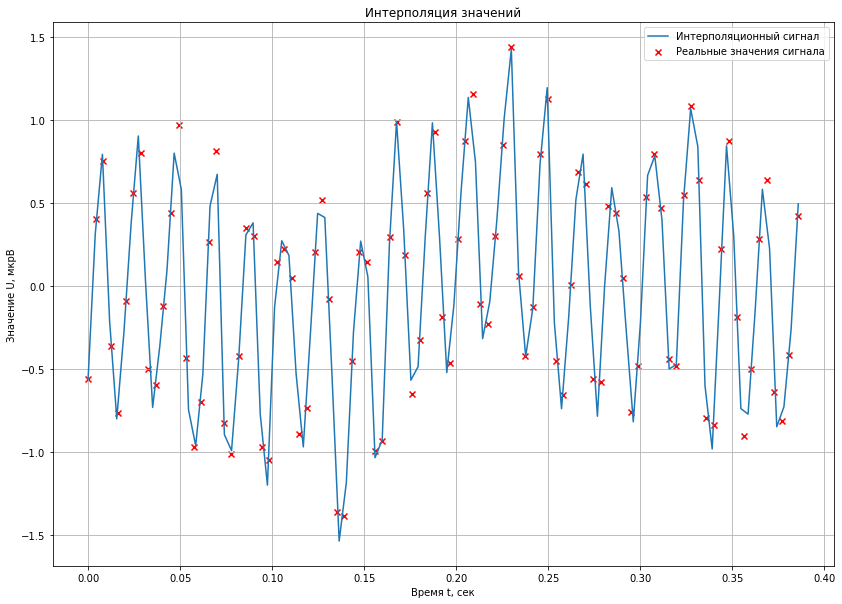

In [16]:
limit = 100
plt.figure(figsize=(14, 10))
plt.grid()
plt.title("Интерполяция значений")
plt.xlabel("Время t, cек")
plt.ylabel("Значение U, мкрВ")
plt.plot(time[:limit], values[:limit])
plt.scatter(data["time"][:limit - 5], data["value"][:limit - 5], c="r", marker="x")
plt.legend(["Интерполяционный сигнал", "Реальные значения сигнала"])

*4. Частотная фильтрация*

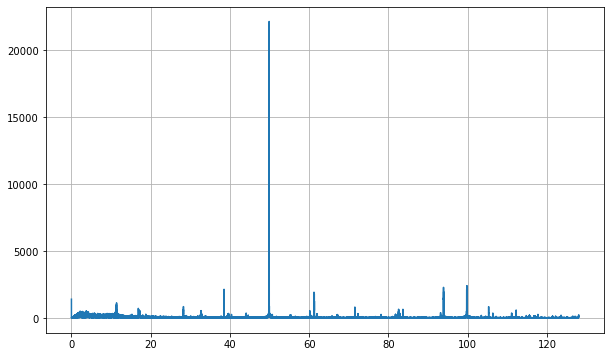

In [19]:
from scipy.fft import rfft, rfftfreq, irfft

yf = rfft(values) # Преобразование Фурье
xf = rfftfreq(len(time), 1./freq) # Частоты для рисования графика

plt.figure(figsize=(10, 6))
plt.plot(xf, np.abs(yf))
plt.grid()

In [21]:
# Убираем частоту 50 Гц - частоту тока
for i in range(len(yf)):
    if xf[i] > 49.8 and xf[i] < 50.2:
        yf[i] = 0

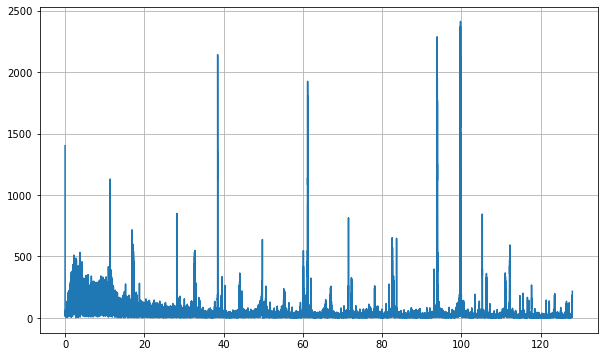

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(xf, np.abs(yf))
plt.grid()

Для демонстрации выведем вручную альфа-ритмы (7-14 Гц)

In [23]:
from copy import deepcopy

alpha_x = deepcopy(xf)
alpha_y = deepcopy(yf)
for i in range(len(yf)):
    if alpha_x[i] < 7 or alpha_x[i] > 14:
        alpha_y[i] = 0

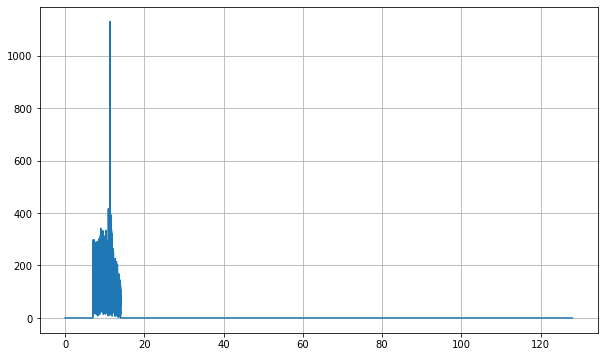

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_x, np.abs(alpha_y))
plt.grid()

In [26]:
from scipy import integrate

print("Площадь под графиком: {}".format(integrate.trapz(np.abs(alpha_y))))

Площадь под графиком: 255607.31099617397


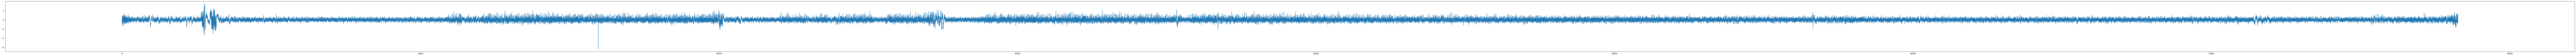

In [27]:
values = irfft(yf) # Обратное преобразование Фурье

plt.figure(figsize=(250, 5))
plt.plot(values)

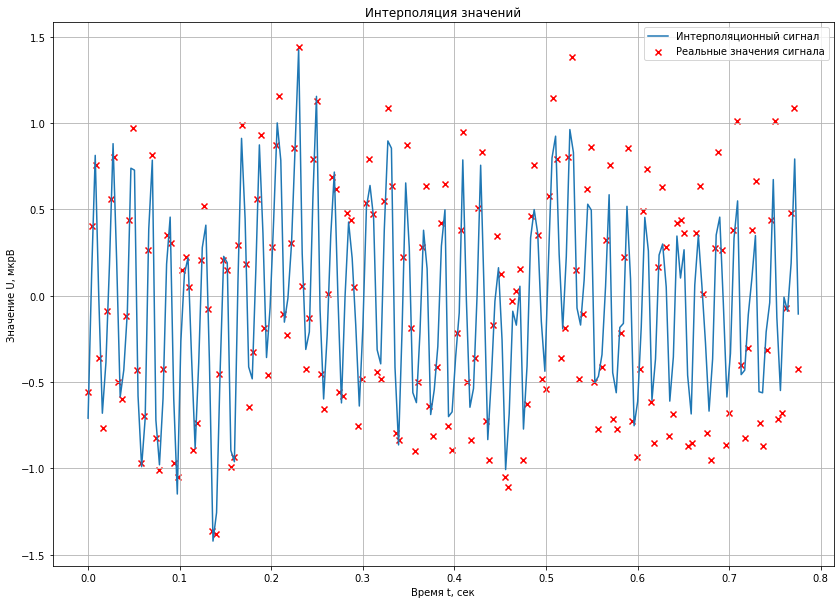

In [28]:
start = 0
limit = 200
alpha = 10
plt.figure(figsize=(14, 10))
plt.grid()
plt.title("Интерполяция значений")
plt.xlabel("Время t, cек")
plt.ylabel("Значение U, мкрВ")
plt.plot(time[start:limit], values[start:limit])
plt.scatter(data["time"][start:limit - alpha], data["value"][start:limit - alpha], c="r", marker="x")
plt.legend(["Интерполяционный сигнал", "Реальные значения сигнала"])

*5. Теперь запишем подготовленные данные в формат EDF для дальнейшего анализа*

In [30]:
from pyedflib import highlevel

signals = np.array(values).reshape(1, -1) # Преобразуем данные
channel_names = ['ch1'] # Указываем название нашего единственного канала
signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=freq) # Формируем формат записи
header = highlevel.make_header(patientname='Nikita', gender='Male') # Указываем информацию о наблюдателе
highlevel.write_edf('basic.edf', signals, signal_headers, header) # Записываем в файл нужного формата

True

## 3. Работа с данными

In [31]:
import mne
from mne import create_info, find_events, Epochs, EpochsArray, set_eeg_reference
import numpy as np

In [32]:
# Считаем данные в нужном формате
raw = mne.io.read_raw_edf('basic.edf',  preload=True)

Extracting EDF parameters from C:\Users\user\Desktop\ИТМО\Нейро\ЭЭГ. Сравнение деятельности. Лаб 2\basic.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78335  =      0.000 ...   305.996 secs...


In [33]:
raw

<RawEDF | basic.edf, 1 x 78336 (306.0 s), ~619 kB, data loaded>

*1. Визуализируем данные*

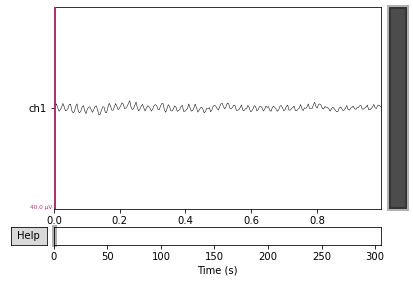

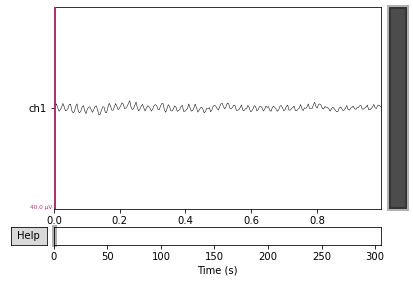

In [34]:
raw.plot(duration=1, n_channels=1)

*2. Рисуем плотность энергетического поля*

Effective window size : 8.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-35-0252658bf14c>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)


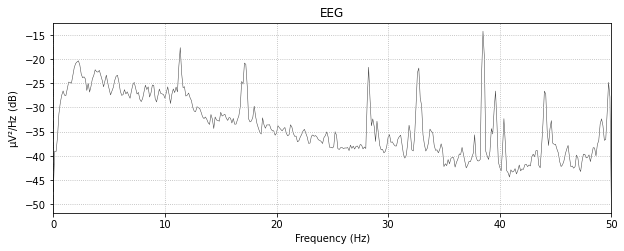

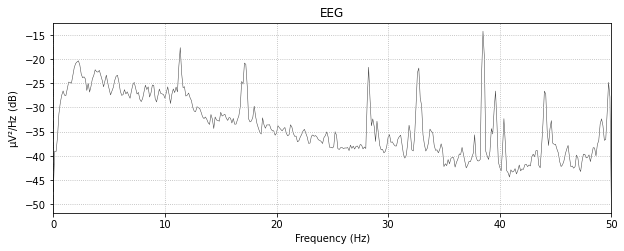

In [35]:
raw.plot_psd(fmax=50)

*3. Определим основные ритмы во время ЭЭГ*

| Волна       | Диапазон, Гц | Амплитуда, мкВ | Кора головного мозга                             | Качество                                                                                                      | Описание                                                                            |
|-------------|--------------|----------------|--------------------------------------------------|---------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| Альфа-ритм  | 7-13         | 5-100          | Теменная, затылочная                             | Спокойное бодрствование с закрытыми глазами, ослабляется при повышенном внимании или концентрации             | +                                                                                   |
| Бетта-ритм  | 14-40        | 0-20           | Задние центральные,  лобные извилины             | Новый стимул, умственное напряжение,  эмоциональное напряжение, характерен для сложных математических задач   | +, так как может при сильном воздействии распространяться на другие области мозга   |
| Гамма-ритм  | 30-120       | 0-15           | Прецентральная, фронтальная, височная и теменная | Задачи, требующие максимального внимания                                                                      | ?, сложно диагностировать, так как он совпадает по частоте с мышечными потенциалами |
| Тетта-ритм  | 4-7          | 20-60          | Гипоталамус                                      | Сон с просмотром сновидений или в состоянии бодрствования - поисковое поведение или эмоциональное состояние   | ?                                                                                   |
| Дельта-ритм | 0,5-3        | 20-200         | -                                                | Связан с глубоким сном. Если во время бодровствования есть этот ритм - патология. Возможны приступы эпилепсии | ?                                                                                   |
|             |              |                |                                                  |                                                                                                               |                                                                                     |

##### Альфа-ритм

In [36]:
def check_sign(sp):
    # Проверяем, чтобы точки хоть как-то возрастались или убывались
    result = []
    mult = 1
    prev = sp[0]
    for i in range(1, len(sp)):
        mult *= sp[i] - sp[i - 1] # Узнаем произведение (чтобы точки не равнялись между собой)
        prev = sp[i]
        result.append(sp[i] - sp[i - 1]) # Узнаём разности (должны быть все положительны или отрицательны)
    
    if len(list(filter(lambda x: x >= 0, result))) in [0, len(result)] and mult > 0:
        return (True, prev, sum(result))
    return (False,)

In [37]:
def find_metrics(sp):
    all_dispertion = []
    prev = 0
    k = 3
    for i in range(k, len(sp) - k):
        # Либо минимум, либо максимум
        check1 = check_sign(sp[i-k:i]) # Узнаем знак последовательности слева (возрастающая или убывающая)
        check2 = check_sign(sp[i+1:i+k+1]) # Узнаем знак последовательности справа (возрастающая или убывающая)
        
        # Проверяем, чтобы все точки слева, и все точки справа были в возрастающей/убывающей последовательности
        # А также чтобы центральная была максимумом или минимумом
        # И ещё вдобавок слева и справа последовательности были противоположны (отрицательно произведение сумм разностей 
        # соответствующих точек)
        if check1[0] and check2[0] and check1[2] * check2[2] < 0 and \
        ((check1[1] < sp[i] and check2[1] > sp[i]) or (check1[1] > sp[i] and check2[1] < sp[i])):
            all_dispertion.append(abs(sp[i] - prev))
            prev = sp[i]
    
    return np.array(all_dispertion)

In [38]:
def find_rithm(raw_data, start, limit, start_freq, end_freq, plot_size, plot_name):
    rithm = raw_data.copy()
    df = rithm.filter(start_freq, end_freq, n_jobs=1).to_data_frame()
    plt.figure(figsize=plot_size)
    plt.plot(df["time"][start:limit] / 256, df["ch1"][start:limit])
    plt.xlabel("Время, с")
    plt.ylabel("Напряжение, мВ")
    plt.title(plot_name)
    plt.grid()
    
    S = integrate.trapz(abs(df["ch1"]))
    extremums = find_metrics(df["ch1"].tolist())
    mean_extremums = np.mean(extremums)
    plt.legend([f"$S_u = {S:.2f}$\n$Extremums = {mean_extremums:.5f}$"])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 423 samples (1.652 sec)



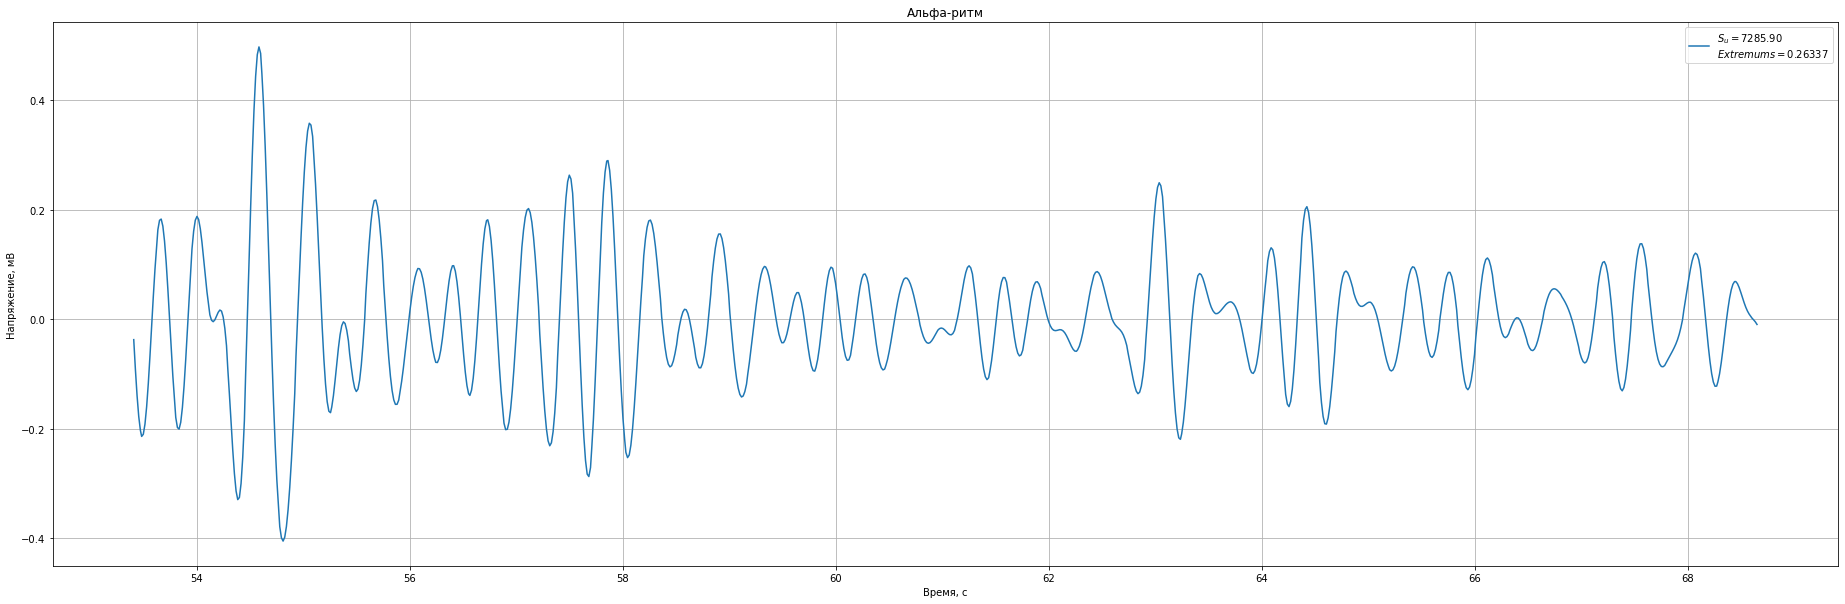

In [39]:
find_rithm(raw, 3500, 4500, 7, 13, (32, 10), "Альфа-ритм")

##### Бетта

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 243 samples (0.949 sec)



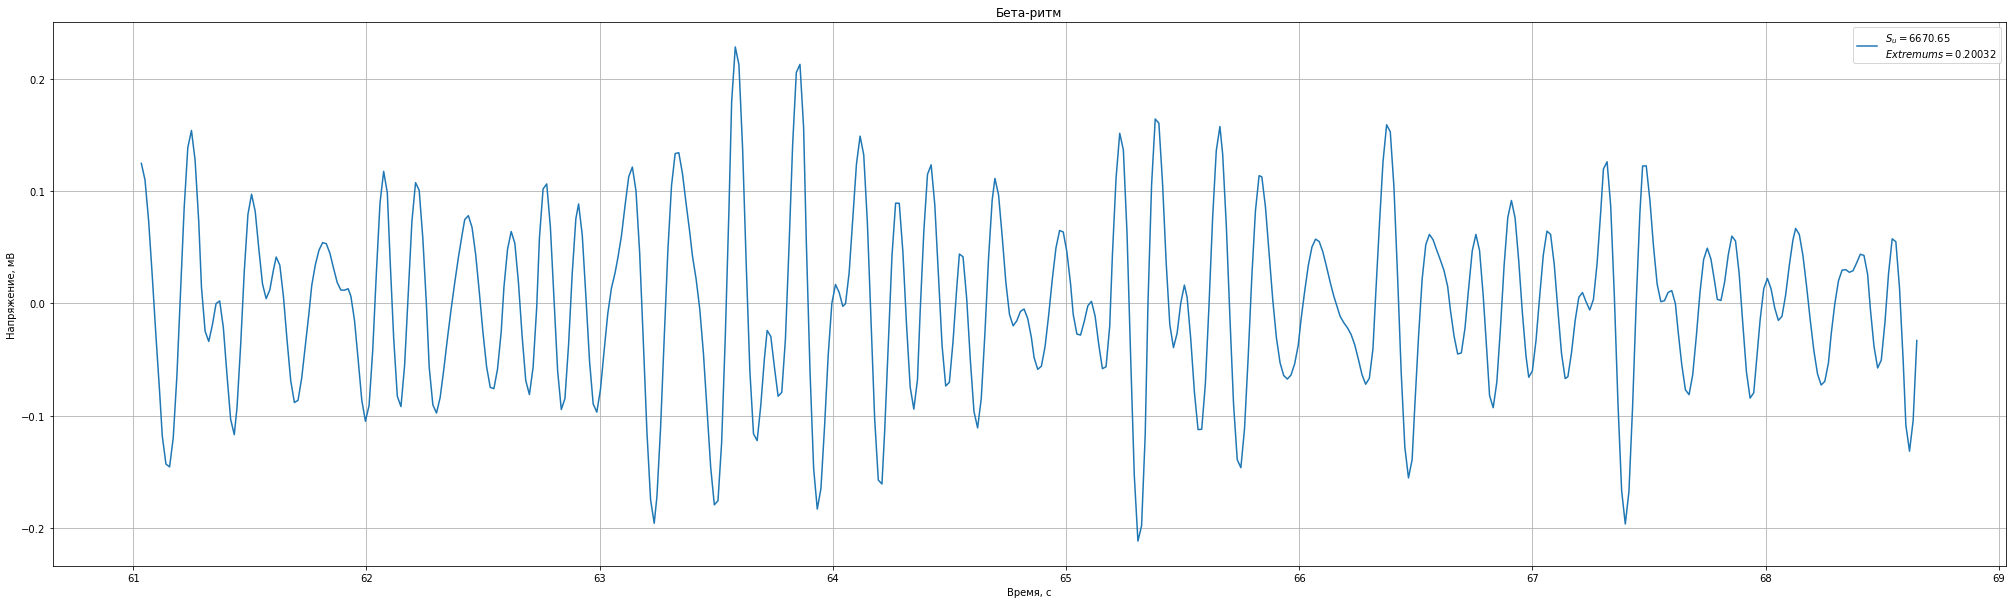

In [40]:
find_rithm(raw, 4000, 4500, 14, 30, (35, 10), "Бета-ритм")

##### Гамма

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 113 samples (0.441 sec)



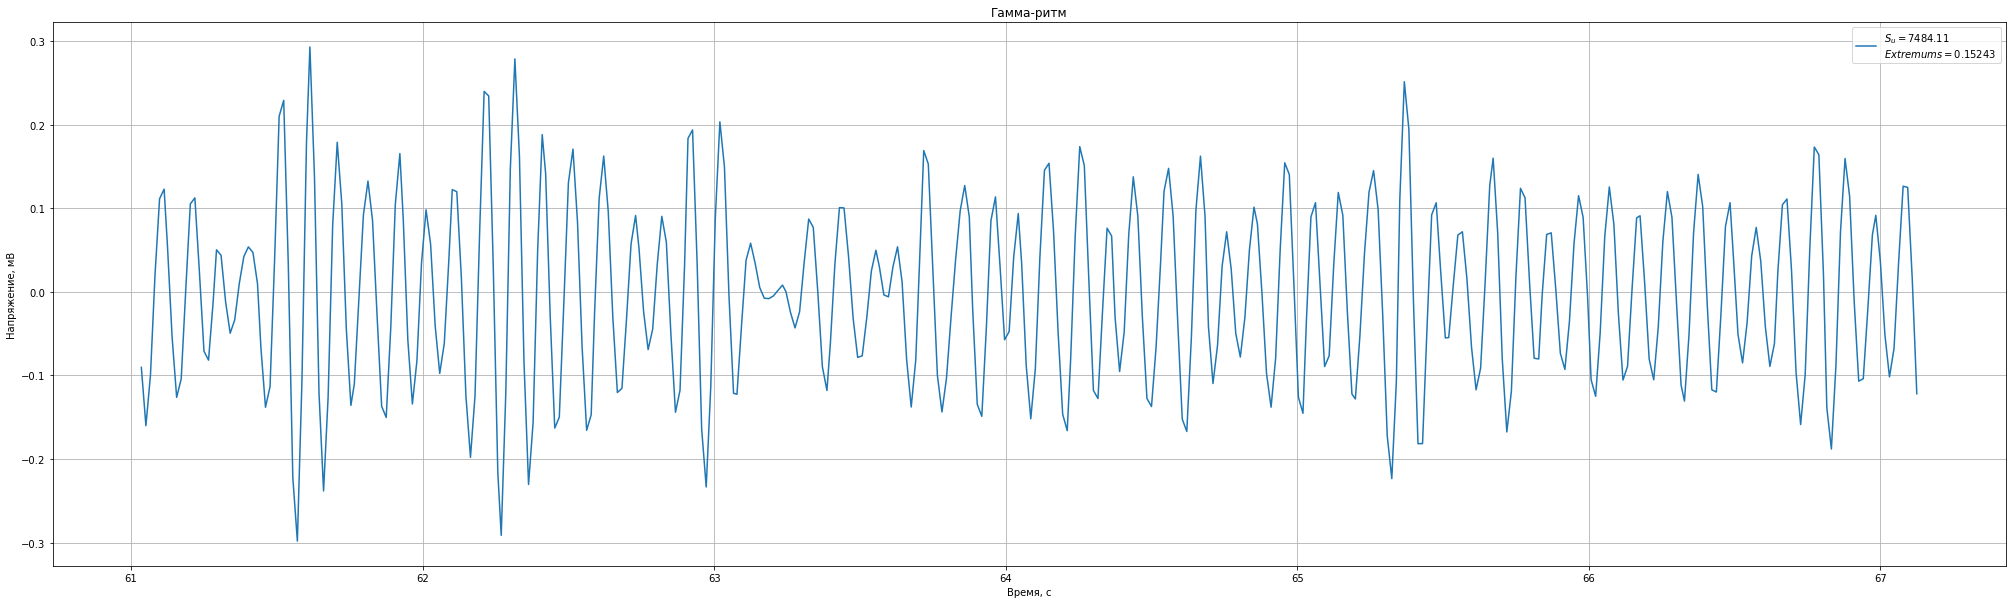

In [41]:
find_rithm(raw, 4000, 4400, 30, 45, (35, 10), "Гамма-ритм")

##### Тетта

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 423 samples (1.652 sec)



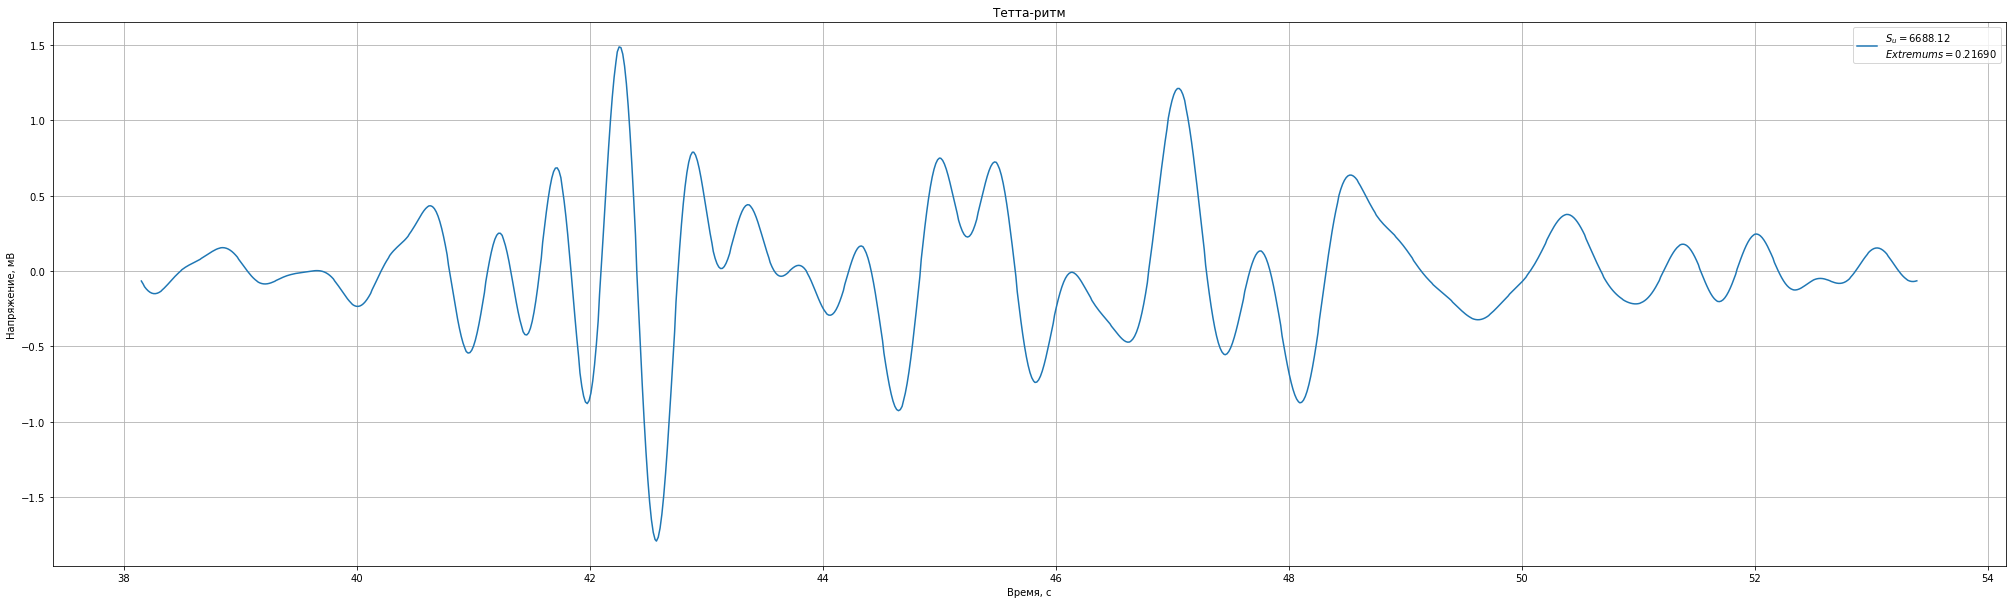

In [42]:
find_rithm(raw, 2500, 3500, 3, 7, (35, 10), "Тетта-ритм")

##### Дельта

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 3.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Filter length: 1691 samples (6.605 sec)



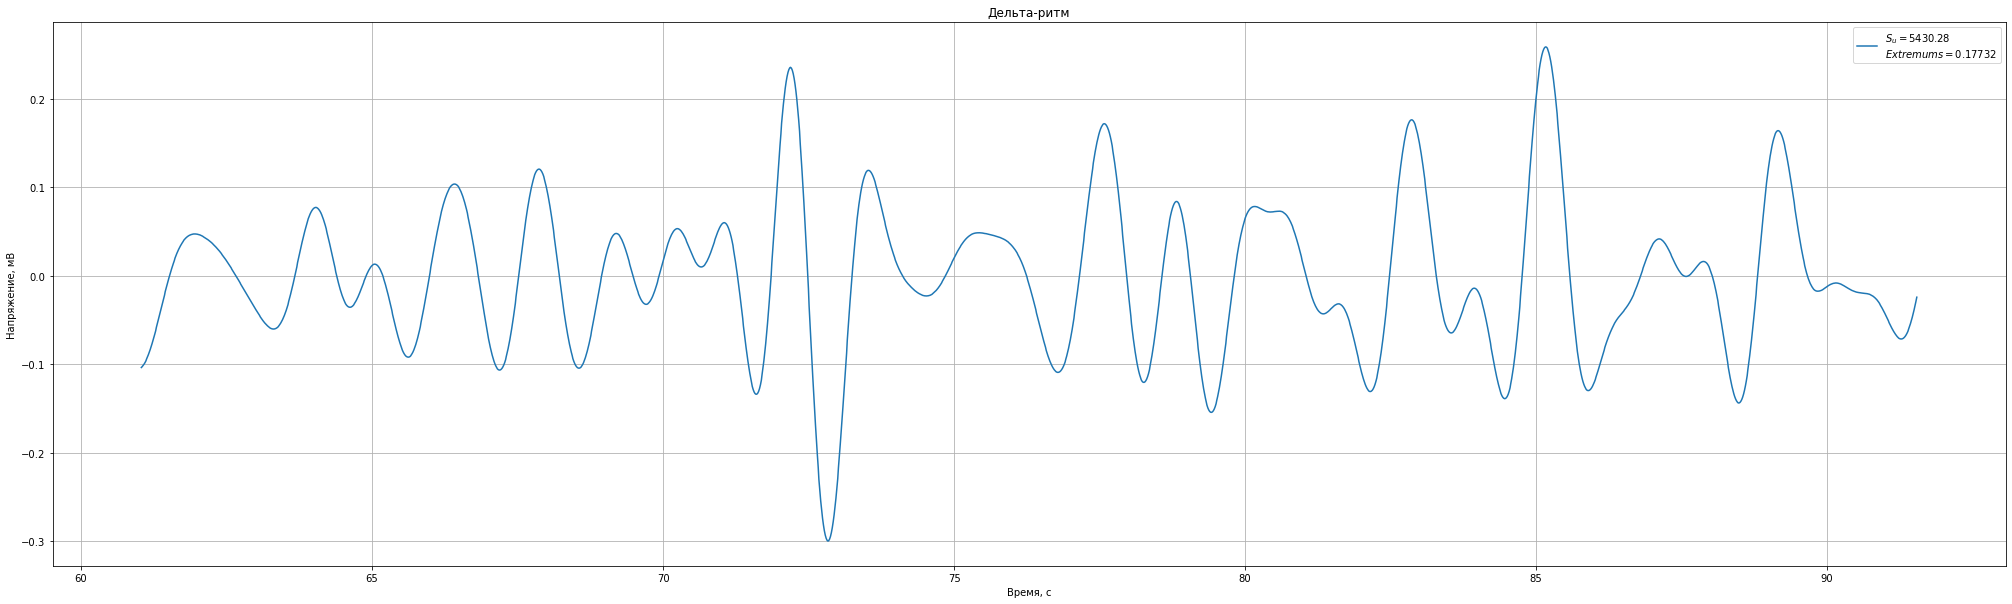

In [43]:
find_rithm(raw, 4000, 6000, 0.5, 3, (35, 10), "Дельта-ритм")

##### Обобщение всех ритмов

In [44]:
rithms = [(7, 13, "Альфа-ритм", 1), (14, 30, "Бета-ритм", 0.8), (30, 45, "Гамма-ритм", 0.4), 
          (3, 7, "Тетта-ритм", 2.3), (0.5, 3, "Дельта-ритм", 3.1)]

In [45]:
def find_rithms(raw_data, start, limit, rithm_data, plot_size, name_research):
    fig, ax = plt.subplots(nrows=len(rithm_data), ncols=1)
    fig.set_size_inches(25, 20)
    for row, (start_freq, end_freq, rithm_name, scale) in zip(ax, rithm_data):
        rithm = raw_data.copy()
        df = rithm.filter(start_freq, end_freq, n_jobs=1).to_data_frame()
        
        end = start + round((limit - start) * scale)
        row.plot(df["time"][start:end] / 256, df["ch1"][start:end])
        row.set_ylabel("Напряжение, мВ")
        row.set_title(rithm_name)
        row.grid()
        
        S = integrate.trapz(abs(df["ch1"]))
        extremums = find_metrics(df["ch1"].tolist())
        mean_extremums = np.mean(extremums)
        row.legend([f"$S_u = {S:.2f}$\n$Extremums = {mean_extremums:.5f}$"])

    ax[-1].set_xlabel("Время, с")    
    plt.savefig(name_research + ".png")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 423 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edg

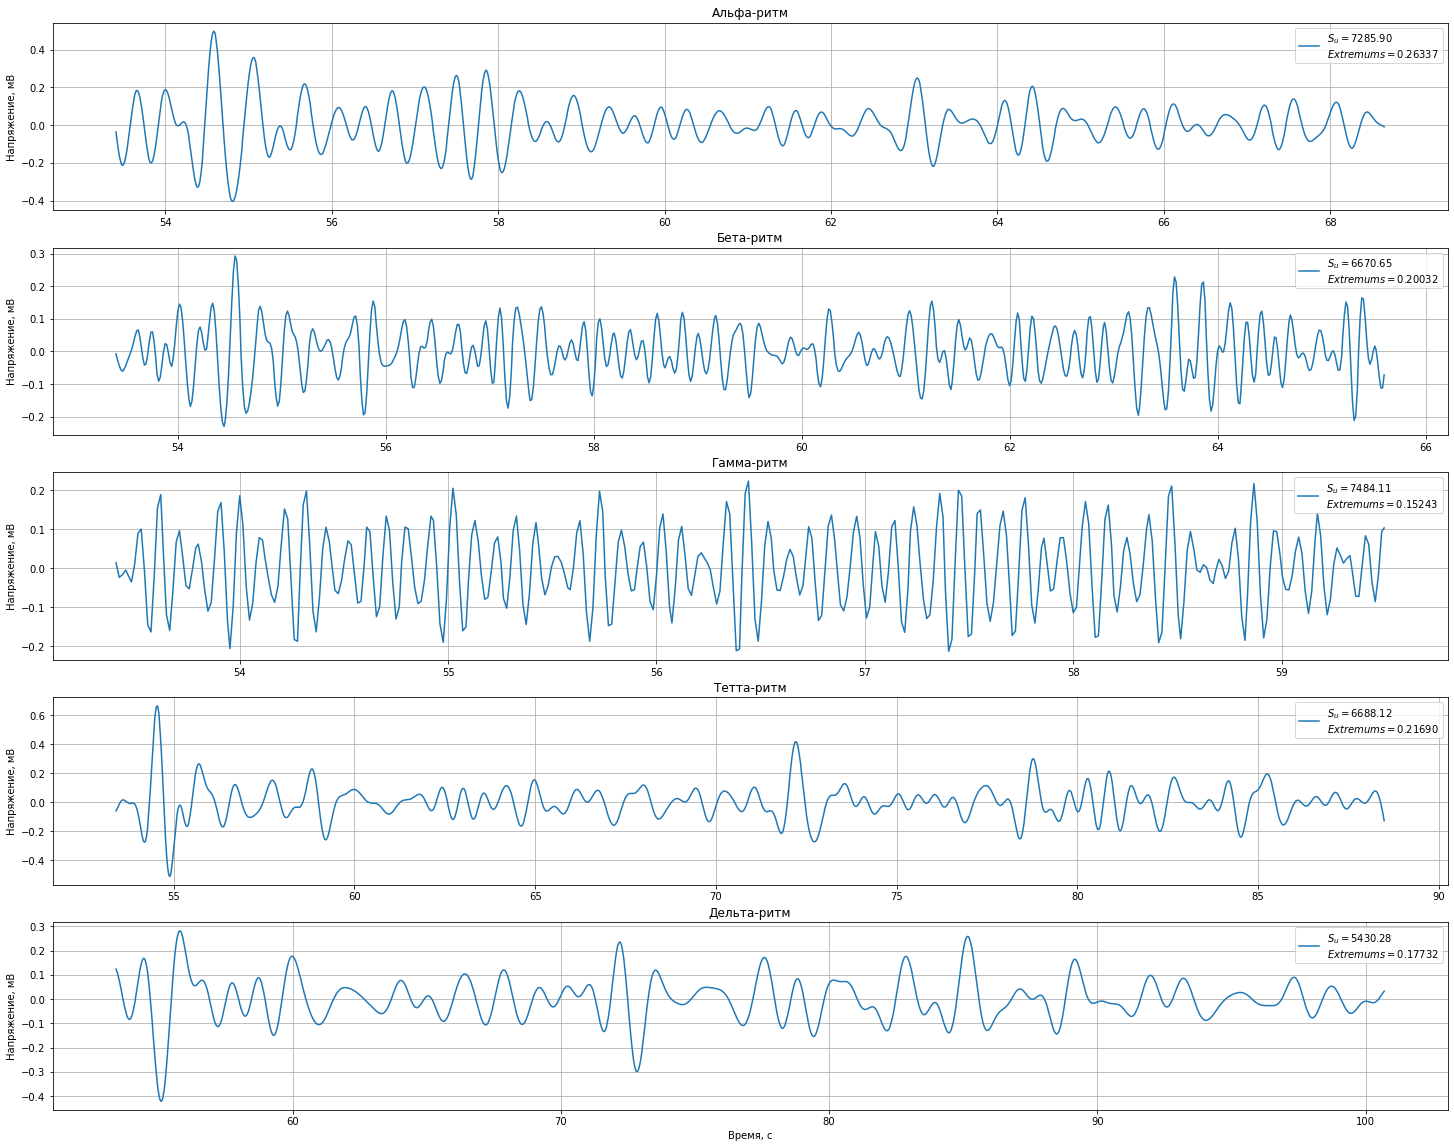

In [46]:
find_rithms(raw, 3500, 4500, rithms, (32, 10), "Релакс с закрытыми глазами")

### Global Field Power

Глобальная мощность поля (GFP) - это мера (неравномерности) электромагнитного поля на датчиках. Обычно он рассчитывается как стандартное отклонение значений датчика в каждый момент времени. Таким образом, это одномерный временной ряд, отражающий пространственную изменчивость сигнала в разных местах расположения датчиков.

In [47]:
iter_freqs = [
    ('Delta', 1, 3),
    ('Theta', 4, 7),
    ('Gamma', 30, 45),
    ('Beta', 13, 25),
    ('Alpha', 7, 13)
]
tmin, tmax = -1., 3.

In [49]:
frequency_map = []
for band, fmin, fmax in iter_freqs:
    # Получаю копию данных
    #raw = raw1.copy()
    raw.load_data()

    # Фильтрую их в соответсвии с их мин. и макс. частотой
    raw.filter(fmin, fmax, n_jobs=1,  
               l_trans_bandwidth=1,  
               h_trans_bandwidth=1)     
    # Связанные эпохи
    epochs = mne.preprocessing.create_eog_epochs(raw, ch_name=raw.ch_names, tmin=-1., tmax=3., baseline=None) 
    epochs.subtract_evoked()

    # Записываю данные про них
    epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))
    del epochs
del raw

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 3.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Filter length: 845 samples (3.301 sec)

Using EOG channel: ch1
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0

In [ ]:
from mne.baseline import rescale
from mne.stats import bootstrap_confidence_interval

def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)

In [ ]:
# Тут код рисует красивые графики на основе всякого
fig, axes = plt.subplots(5, 1, figsize=(15, 15), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 5))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel('Time [ms]')
plt.savefig("basic.png")

### Вывод:

Таким образом, мы опознали основные ритмы и подсчитали некоторые их характеристики

**Задачи на программирование**
![](https://drive.google.com/uc?export=view&id=19ncwjIWnWqrer5XEDn7LoSU2B9Qwh1fh)

**Игра в компьютер**
![](https://drive.google.com/uc?export=view&id=1LhTkaDo9hEdh-yhZmcZK0RdI9S6FGf_q)

**Задачи по математике**
![](https://drive.google.com/uc?export=view&id=1gjqljh8wqeZ2QwcoW7r-MKfQn_W9SGKo)

**Релакс с музыкой**
![](https://drive.google.com/uc?export=view&id=1dtAYTKtr9FJ-RsE9qpyqjwjIFkP7jlRF)

**Релакс с закрытыми глазами**
![](https://drive.google.com/uc?export=view&id=13oRuPA580a1TN6JMdttYlmxleuO_0cKL)